# Intraday Momentum

The genesis of this paper is from http://www.smallake.kr/wp-content/uploads/2015/01/SSRN-id2440866.pdf, which relates the first half hour of trading to the last half hour of trading. We will seek to replicate the results for the EEM Index (MSCI Emerging Markets), before exploring other local ETFs and Futures such as Hang Seng Tracker Fund, China A50 Index, MSCI Taiwan ETF. 

In [1]:
# We hate warnings
import warnings
warnings.simplefilter('ignore')

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
import math
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm

In [2]:
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def create_custom_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's returns.
    - Fetches benchmarks, then creates the plots on a single figure.
    - Plots: rolling returns (with cone), rolling beta, rolling sharpe,
        rolling Fama-French risk factors, drawdowns, underwater plot, monthly
        and annual return plots, daily similarity plots,
        and return quantile box plot.
    - Will also print the start and end dates of the strategy,
        performance statistics, drawdown periods, and the return range.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - See full explanation in create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    returns = returns[returns.index > benchmark_rets.index[0]]

    pf.show_perf_stats(returns, benchmark_rets)

    pf.show_worst_drawdown_periods(returns)

    # If the strategy's history is longer than the benchmark's, limit strategy
    if returns.index[0] < benchmark_rets.index[0]:
        returns = returns[returns.index > benchmark_rets.index[0]]

    vertical_sections = 12

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if bootstrap:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_rolling_returns = plt.subplot(gs[:2, :])

    i = 2
    ax_rolling_returns_vol_match = plt.subplot(gs[i, :],
                                               sharex=ax_rolling_returns)
    i += 1
    ax_rolling_returns_log = plt.subplot(gs[i, :],
                                         sharex=ax_rolling_returns)
    i += 1
    ax_returns = plt.subplot(gs[i, :],
                             sharex=ax_rolling_returns)
    i += 1
    ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_drawdown = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_monthly_heatmap = plt.subplot(gs[i, 0])
    ax_annual_returns = plt.subplot(gs[i, 1])
    ax_monthly_dist = plt.subplot(gs[i, 2])
    i += 1
    ax_return_quantiles = plt.subplot(gs[i, :])
    i += 1

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title(
        'Cumulative returns')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=None,
        volatility_match=True,
        legend_loc=None,
        ax=ax_rolling_returns_vol_match)
    ax_rolling_returns_vol_match.set_title(
        'Cumulative returns volatility matched to benchmark')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        logy=True,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns_log)
    ax_rolling_returns_log.set_title(
        'Cumulative returns on logarithmic scale')

    pf.plot_returns(
        returns,
        live_start_date=live_start_date,
        ax=ax_returns,
    )
    ax_returns.set_title(
        'Returns')

    pf.plot_rolling_beta(
        returns, benchmark_rets, ax=ax_rolling_beta)

    pf.plot_rolling_volatility(
        returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    pf.plot_rolling_sharpe(
        returns, ax=ax_rolling_sharpe)

    # Drawdowns
    pf.plot_drawdown_periods(
        returns, top=5, ax=ax_drawdown)

    pf.plot_drawdown_underwater(
        returns=returns, ax=ax_underwater)

    pf.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    pf.plot_annual_returns(returns, ax=ax_annual_returns)
    pf.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    pf.plot_return_quantiles(
        returns,
        live_start_date=live_start_date,
        ax=ax_return_quantiles)

    if bootstrap:
        ax_bootstrap = plt.subplot(gs[i, :])
        pf.plot_perf_stats(returns, benchmark_rets,
                                 ax=ax_bootstrap)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


First, I would like to investigate the average daily trading volume of each 30 minute interval to determine if the opening and closing hours are more active than the rest of the day.

In [3]:
data = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\EEM\EEM.csv', index_col=0)
data.index = pd.to_datetime(data.index, format = '%d/%m/%Y %H:%M')

In [4]:
# Adjust the data to take into account daylights savings
a = data.index[:336].shift(-1, 'H')
b = data.index[336:]
data.index = a.append(b)

In [5]:
hour = [21, 22, 23, 0, 1, 2, 3]
min = [0, 30]
full_time = [(x, y) for x in hour for y in min][1:]

In [6]:
avg_vol = pd.Series()

for t in full_time:
     avg_vol[datetime.time(t[0], t[1])] = data['Volume'][data.index.time == datetime.time(t[0], t[1])].mean()

Text(0.5,1,'Average Traded Volume')

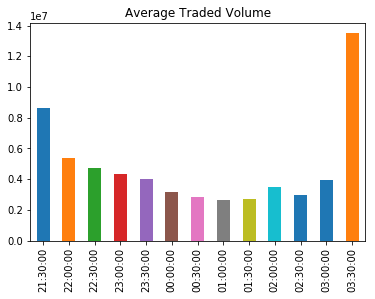

In [7]:
avg_vol.plot.bar()
plt.title('Average Traded Volume')

As expected, the opening half-hour (21:30) and the closing half-hour (03:30) are indeed more active than expected. Now, let's try to calculate the opening half-hour returns and the closing half-hour returns, before running a simple OLS regression.

To do so, we will be using the mid bid-ask data to calculate the trade prices.

In [8]:
# Read the open bid data 
open_bid = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\EEM\EEM Open Bid.csv', 
                       index_col=0)
open_bid.index = pd.to_datetime(open_bid.index, format = '%d/%m/%Y %H:%M')

# Read the open ask data
open_ask = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\EEM\EEM Open Ask.csv', 
                       index_col=0)
open_ask.index = pd.to_datetime(open_ask.index, format = '%d/%m/%Y %H:%M')

# Do a inner merge on both bid and ask for the open data
open_data = open_bid.merge(open_ask, left_index=True, right_index=True)

# Calculate the mid-price using (bid+ask)/2
open_data['Mid'] = 0.5 * (open_data['Bid'] + open_data['Ask'])

In [9]:
# Adjust the data for daylights savings
a = open_data.index[:170].shift(-1, 'H')
b = open_data.index[170:]
open_data.index = a.append(b)

In [10]:
# Read the close bid data 
close_bid = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\EEM\EEM Close Bid.csv', 
                       index_col=0)
close_bid.index = pd.to_datetime(close_bid.index, format = '%d/%m/%Y %H:%M')

# Read the close ask data
close_ask = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\EEM\EEM Close Ask.csv', 
                       index_col=0)
close_ask.index = pd.to_datetime(close_ask.index, format = '%d/%m/%Y %H:%M')

# Do a inner merge on both bid and ask for the close data
close_data = close_bid.merge(close_ask, left_index=True, right_index=True)

# Calculate the mid-price using (bid+ask)/2
close_data['Mid'] = 0.5 * (close_data['Bid'] + close_data['Ask'])

In [11]:
# Adjust the data for daylights savings
a = close_data.index[:170].shift(-1, 'H')
b = close_data.index[170:]
close_data.index = a.append(b)

In [12]:
# Set the closing hour
closing_time = datetime.time(3, 30)

# Calculate the returns for the closing half-hour
close_ret = (close_data['Mid'][close_data.index.time == closing_time] / open_data[
    'Mid'][open_data.index.time == closing_time]) - 1
close_ret.index = close_ret.index.normalize()

In [13]:
# Half hour before closing
pre_closing_time = datetime.time(3, 0)

# Calculate the returns for the 1hour before closing 
pre_close_ret = (close_data['Mid'][close_data.index.time == pre_closing_time] / open_data[
    'Mid'][open_data.index.time == pre_closing_time]) - 1
pre_close_ret.index = pre_close_ret.index.normalize()

In [14]:
# Read the previous close bid data 
p_close = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\EEM\EEM Previous Close.csv', 
                       index_col=0)
p_close.index = pd.to_datetime(p_close.index, format = '%d/%m/%Y %H:%M')
p_close.index = p_close.index.normalize()

In [15]:
# Set the opening hour
opening_time = datetime.time(21, 30)

# Read the close for the first half-hour open and normalize the data 
open_close = pd.DataFrame(close_data['Mid'][close_data.index.time == opening_time])
open_close.index = open_close.index.normalize()
open_close = open_close[1:-1]

close_close = pd.DataFrame(close_data['Mid'][close_data.index.time == closing_time])
close_close.index = close_close.index.normalize()
close_close = close_close[:-1]
close_close.index = open_close.index

In [16]:
open_ret = open_close / close_close - 1

In [17]:
X = pd.DataFrame(index=open_ret[1:].index)

past_opening_day_ret = open_ret.shift(1).dropna()
X['Past Opening Day Ret'] = past_opening_day_ret

past_closing_day_ret = close_ret[1:-1]
past_closing_day_ret.index = past_opening_day_ret.index
X['Past Closing Day Ret'] = past_closing_day_ret

pre_past_closing_day_ret = pre_close_ret[1:-1]
pre_past_closing_day_ret.index = past_opening_day_ret.index
X['Pre_past_closing_day_ret'] = pre_past_closing_day_ret

a = X['Past Opening Day Ret']
b = X['Past Closing Day Ret']
c = X[['Pre_past_closing_day_ret', 'Past Opening Day Ret']]
y = open_ret[1:]

## Ordinary Least Square Regression

I previously tested out the result of regressing the open half-hour return with the close half-hour return. However, the R^2 was a insignificant 0.007 and the coefficient was even negative, indicating that the intraday momentum relationship documented by the researchers has broken down. :(

However, the paper did mention an interesting caveat. They mentioned that the opening prices the next day tend to drop (rise) after the ETF has performed well  during the opening half-hour (and by the intraday momentum effect documented, the closing half-hour as well). Therefore, this effect points towards a mean-reverting phenomenon between the past open half-hour return and next day open half-hour return.

In [20]:
model = sm.OLS(y, a).fit()
predictions = model.predict(a)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Mid   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     4.699
Date:                Wed, 22 Aug 2018   Prob (F-statistic):             0.0320
Time:                        00:43:08   Log-Likelihood:                 425.26
No. Observations:                 133   AIC:                            -848.5
Df Residuals:                     132   BIC:                            -845.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Past Opening Day Ret    -0.1843      0.085     -2.168      0.032      -0.353      -0.016
==============================================================================
Omnibus:                        5.338   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.245
Skew:                          -0.331   Prob(JB):                       0.0726
Kurtosis:                       3.713   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The result that I obtained fits well with my hypothesis that the past open  half-hour return has a mean reverting relationship with the next open half-hour return. Therefore, we should long (short) the ETF at close if it has a negative (positive) open half-hour return and close it at 10am the next day.

In [29]:
df = pd.DataFrame()

# For our strategy, go opposite of the previous day open (include a 0.05% transaction cost)
df['Strat_Daily_rets'] = (-np.sign(a) * y['Mid'])
df['Long_Strat_Daily_rets'] = (-np.sign(a) * y['Mid'] * (a<0).astype('int')) 
df['Short_Strat_Daily_rets'] = (-np.sign(a) * y['Mid'] * (a>0).astype('int')) 

# Our benchmark of always going long on the opening half-hour 
df['Benchmark_rets'] = y['Mid']

# Calculate the cumulative returns of our strategy
df['Strat_perc_ret'] = (1 + df.Strat_Daily_rets).cumprod() - 1
df['Benchmark_perc_ret'] = (1 + df.Benchmark_rets).cumprod() - 1

## Results of our strategy


### Strategy 1

Everyday, before closing go long (short) when the opening returns is negative (positive). Close the trade the next day at 10am. 

Backtest months: 6


,Backtest
Annual return,79.2%
Cumulative returns,35.7%
Annual volatility,15.6%
Sharpe ratio,3.83
Calmar ratio,19.47
Stability,0.92
Max drawdown,-4.1%
Omega ratio,1.88
Sortino ratio,6.86
Skew,0.18


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.07,2018-05-01,2018-05-14,2018-05-17,13
1,3.93,2018-06-15,2018-06-19,2018-06-25,7
2,3.82,2018-07-06,2018-07-19,2018-07-27,16
3,3.56,2018-03-08,2018-03-23,2018-04-03,19
4,2.14,2018-04-09,2018-04-17,2018-04-25,13


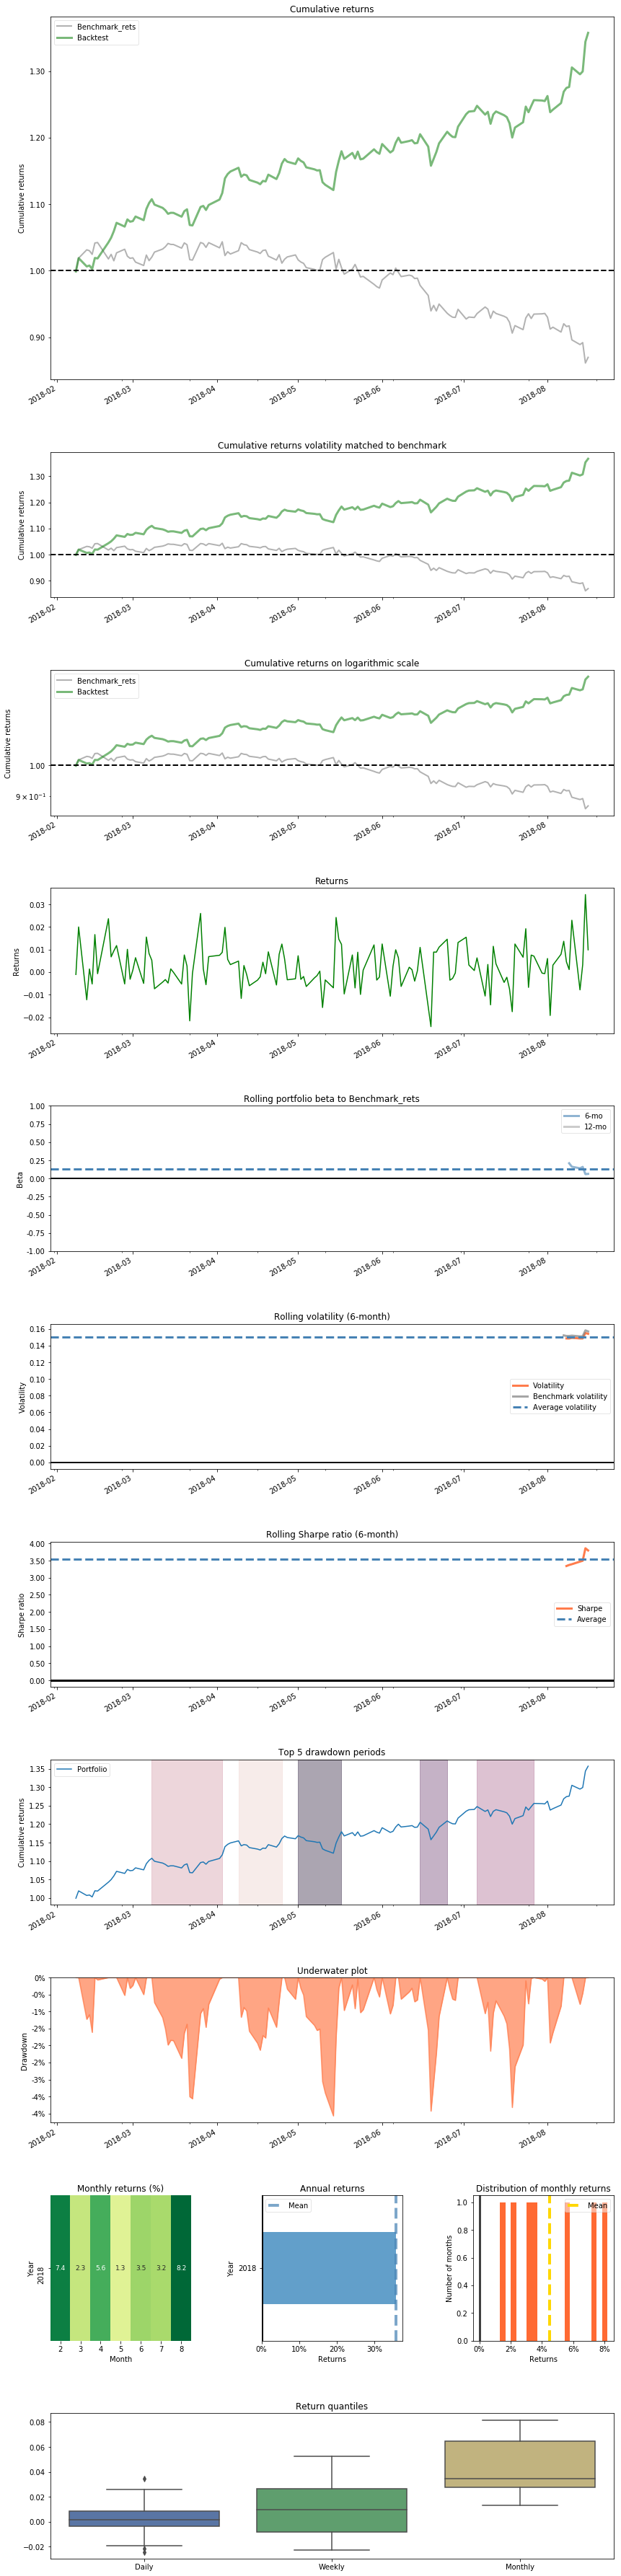

In [30]:
create_custom_tear_sheet(returns=df['Strat_Daily_rets'], benchmark_rets=df['Benchmark_rets'])

### Strategy 2

Everyday, before closing go long when the opening returns is negative. Close the trade the next day at 10am.

Backtest months: 6


,Backtest
Annual return,17.9%
Cumulative returns,9.0%
Annual volatility,11.6%
Sharpe ratio,1.48
Calmar ratio,3.84
Stability,0.27
Max drawdown,-4.7%
Omega ratio,1.38
Sortino ratio,2.31
Skew,0.03


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.66,2018-06-07,2018-06-19,NaT,NaN
1,2.22,2018-03-21,2018-03-23,2018-03-26,4
2,1.80,2018-04-11,2018-05-31,2018-06-06,41
3,0.73,2018-02-27,2018-03-05,2018-03-06,6
4,0.56,2018-03-27,2018-03-28,2018-03-29,3


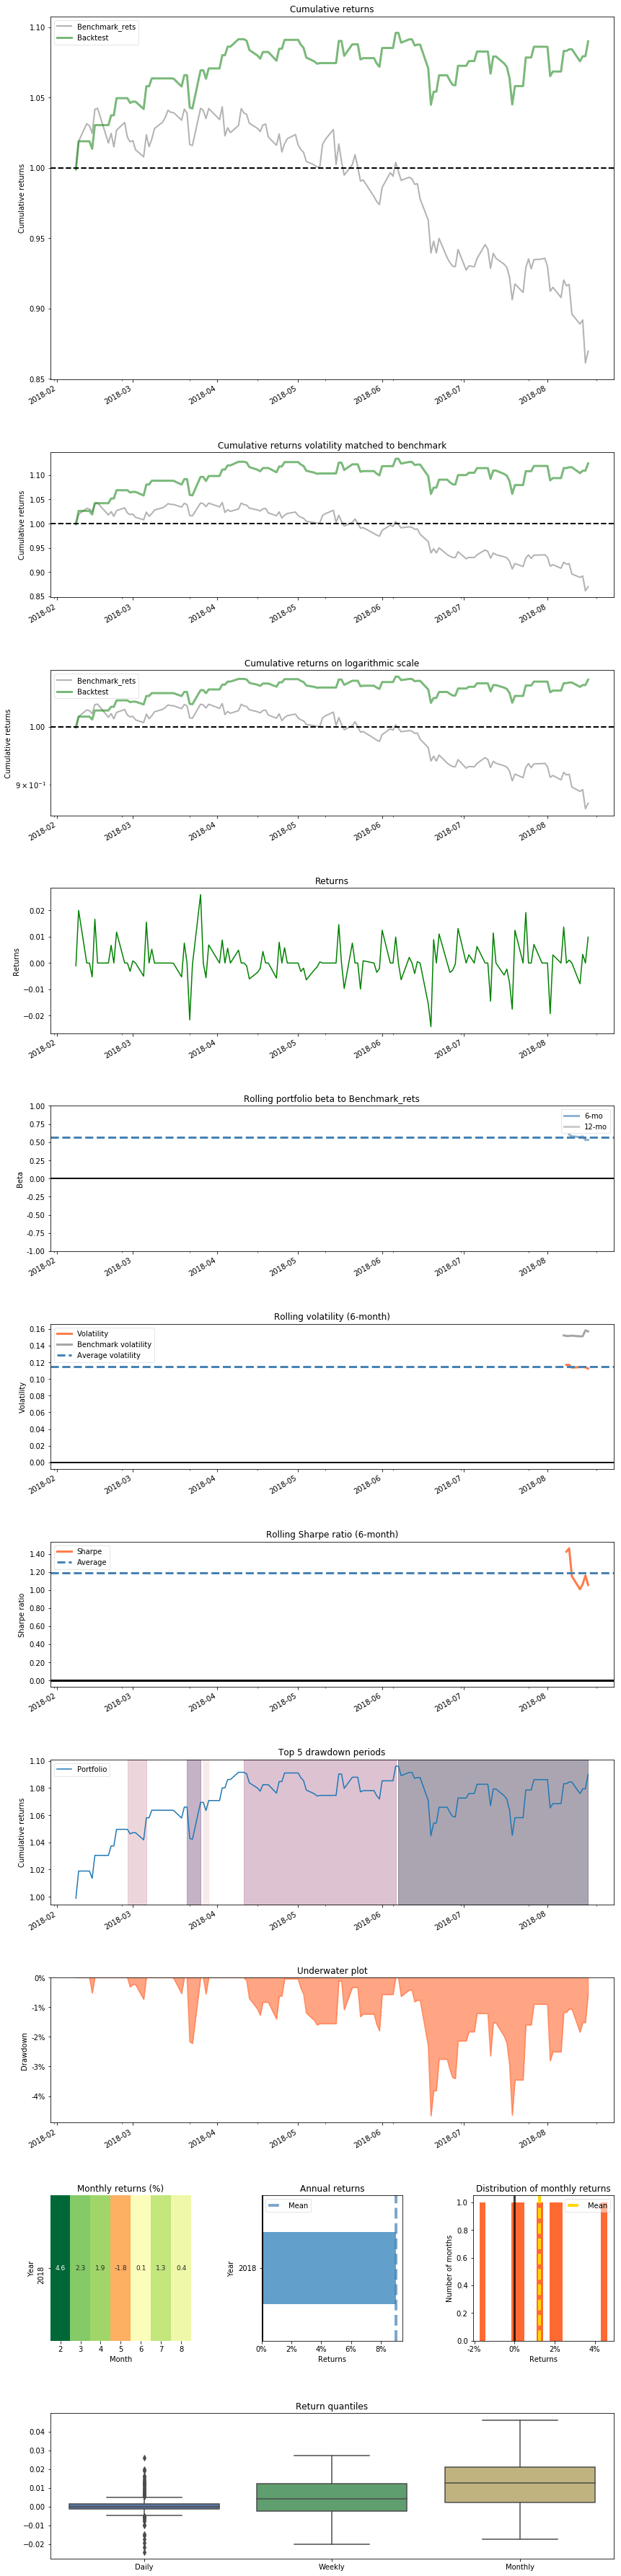

In [25]:
create_custom_tear_sheet(returns=df['Long_Strat_Daily_rets'], benchmark_rets=df['Benchmark_rets'])

### Strategy 3

Everyday, before closing go short when the opening returns is positive. Close the trade the next day at 10am.

Backtest months: 6


,Backtest
Annual return,52.0%
Cumulative returns,24.5%
Annual volatility,10.7%
Sharpe ratio,3.97
Calmar ratio,20.04
Stability,0.94
Max drawdown,-2.6%
Omega ratio,2.87
Sortino ratio,9.38
Skew,1.68


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.60,2018-05-09,2018-05-14,2018-05-17,7
1,1.98,2018-03-08,2018-03-14,2018-04-04,20
2,1.23,2018-02-09,2018-02-12,2018-02-20,8
3,1.17,2018-04-09,2018-04-10,2018-04-25,13
4,1.07,2018-06-01,2018-06-04,2018-06-15,11


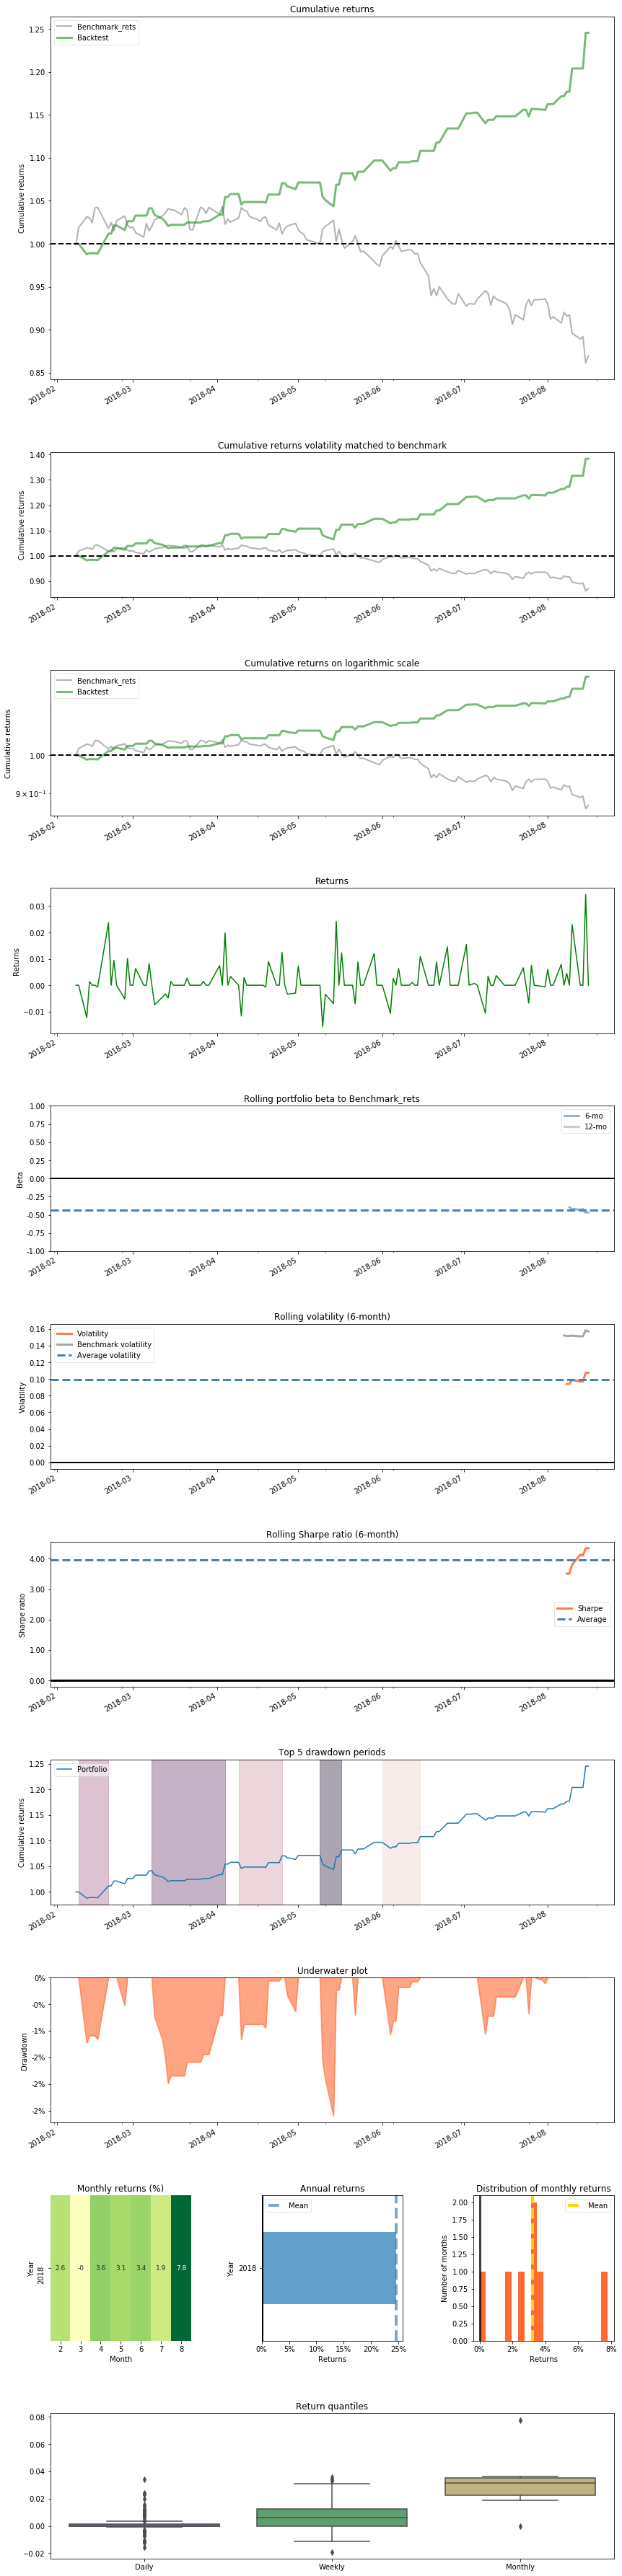

In [26]:
create_custom_tear_sheet(returns=df['Short_Strat_Daily_rets'], benchmark_rets=df['Benchmark_rets'])

### Buy & Hold

In [266]:
# returns for a buy and hold 
close_data['Mid'][-1] / open_data['Mid'][0] - 1 

-0.1069892473118278

In [279]:
close_data[close_data.index.time == closing_time]

,Bid,Ask,Mid
Dates,,,
2018-02-06 03:30:00,47.42,47.45,47.435
2018-02-07 03:30:00,48.89,48.89,48.890
2018-02-08 03:30:00,47.32,47.33,47.325
2018-02-09 03:30:00,45.71,45.75,45.730
2018-02-10 03:30:00,46.44,46.45,46.445
2018-02-13 03:30:00,47.25,47.26,47.255
2018-02-14 03:30:00,47.53,47.54,47.535
2018-02-15 03:30:00,48.69,48.70,48.695
2018-02-16 03:30:00,49.44,49.45,49.445
